# Introduction

Within this project, we will be working with housing data from the city of Ames, Iowa, United States. This data spans from years 2006 to 2010. For a link on the information of the housing data, follow here: https://s3.amazonaws.com/dq-content/307/data_description.txt. To see the column descriptions, click on the 'AmesHousing.tsv' file in the relative folder. For the source of the data, see https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627.


The purpose of this project is to develop a linear regression model that will predict these house prices within the training and test set. 

Let us first import all the *modules* necessary for this exploration: 

In [67]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import warnings
import matplotlib.pyplot as plt
from scipy import stats as st
from pandas.core.common import SettingWithCopyWarning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA

We will now read the file in and creating functions that will ease this exploration and be re-used and modified throughout this project.

In [68]:
house = pd.read_csv('AmesHousing.tsv', delimiter= "\t")

In [69]:
def variance_cutoff(df, cutoff):
    variances =df.var()
    variance_bool = variances > cutoff
    newvariances = variances[variance_bool]
    return newvariances.index

In [70]:
def select_features(df, corr_cutoff):
    house_num = housetr.select_dtypes(include=['int64','float64'])
    house_corr = house_num.corr()
    house_corr_saleprice = abs(house_corr['SalePrice'])
    housecorrbool = house_corr_saleprice > corr_cutoff
    refined_corrs = house_corr_saleprice[housecorrbool]
    return refined_corrs.index.drop('SalePrice')

In [71]:
def transform_features(df):
    warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
    
    # Eliminates columns with more than 25% of null values
    null_counts = df.isnull().sum()
    bool_1 = null_counts < 0.25 * df.shape[0]
    modified = df[null_counts[bool_1].index]
    
    # Selects numerical columns with 5% or less null values
    numerical = modified.select_dtypes(include=['int64','float64'])
    numerical_null_counts = numerical.isnull().sum()
    numerical_null_bool = numerical_null_counts < 0.05*df.shape[0]
    numerical_low_null = modified[numerical_null_counts
                                  [numerical_null_bool].index]
    
    # Fills all the numerical columns with <5% null values with its respective mode 
    for col in numerical_low_null.columns:
        numerical_low_null[col] = numerical_low_null[col].fillna(numerical_low_null[col].value_counts().index[0])
    modified[numerical_low_null.columns] = numerical_low_null.copy()
    
    # Otherwise fills the rest of numerical between 5-25% with its mean
    for col in numerical.columns:
        modified[col] = modified[col].fillna(np.mean(modified[col])) 
        
    return modified

In [72]:
def pc_analysis(df, n):
    pca = PCA(n_components=n)
    pca.fit(df)
    variance_ratios = pca.explained_variance_ratio_.cumsum()*100
    print("Cumulative Variance:")
    print(variance_ratios)
    plt.plot(range(1,1+len(variance_ratios)), variance_ratios)
    plt.xlabel('# of components')
    plt.ylabel('cumulative variance')
    plt.show()
    return pca

In [73]:
# The purpose of this function is to train and test the given data-set via multiple techniques depending on the k-value
# given, speicfying how many folds wanted

def train_and_test(df,k): 
    warnings.simplefilter(action="ignore", category=FutureWarning)
    lr = LinearRegression()
    if 'SalePrice' in df.columns:
        feature_list = df.drop(['SalePrice'],axis=1).columns
    if 'SalePrice' not in df.columns: 
        feature_list = df.columns
        df['SalePrice'] = house['SalePrice']
    
    # If number of splits desired is greater than 1, performs K-Fold Cross Validation
    if k>1:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        mses = cross_val_score(lr, df[feature_list], df['SalePrice'], 
                           scoring='neg_mean_squared_error', cv=kf)
        mses_abs = abs(mses)
        rmses = mses_abs**(1/2)
        rmse_avg = np.mean(rmses)
        
        return rmse_avg
    
    # If number of splits is equal to one, it will split the dataset into two folds, performing training on one fold 
    # and testing on the other, and vice versa, averaging the yield RMSEs. 
    
    if k==1:
        np.random.seed(1)
        shuffle_index = np.random.permutation(df.index)
        df = df.reindex(shuffle_index)
        
        fold_one = df.iloc[0:1460]
        fold_two = df.iloc[1460:]
        
        lr.fit(fold_one[feature_list], fold_one['SalePrice'])
        predict_1 = lr.predict(fold_two[feature_list])
        
        mse_1 = mean_squared_error(predict_1, fold_two['SalePrice'])
        
        lr.fit(fold_two[feature_list], fold_two['SalePrice'])
        
        predict_2 = lr.predict(fold_one[feature_list])
        mse_2 = mean_squared_error(predict_2, fold_one['SalePrice'])
        
        rmse_avg = (np.mean(mse_1 + mse_2))**(1/2)
        
        return rmse_avg 
    
    # If the value of k==0, performs a basic 50/50 split for train/test validation. 
    
    else:
        train = df.iloc[0:1460]
        test = df.iloc[1460:]
        lr.fit(train[feature_list], train['SalePrice'])
        predictions = lr.predict(test[feature_list])
        mse_list = mean_squared_error(predictions, test['SalePrice'])
        rmse_avg = (np.mean(mse_list))**(1/2)
        
        return rmse_avg

# Feature Engineering & Data Cleaning

Let us now begin to remove features with missing values, find features that can be categorial, transform text/numerical columns. We can define a function transform_features() to do all of these operations for us.

In [74]:
housetr = transform_features(house)

In [75]:
housetr.select_dtypes(include=['object']).isnull().sum().value_counts()

0      27
80      3
159     3
23      1
83      1
81      1
1       1
157     1
dtype: int64

Let us explore the dataset further to see if we can better capture some of the information in the feature columns. We will also see if columns need to be dropped if they aren't useful for machine learning or leak data about final sale.

In [76]:
housetr.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,189900


In [77]:
# Exploring year columns
housetr[['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold']]

,Year Built,Year Remod/Add,Garage Yr Blt,Yr Sold
0,1960,1960,1960.000000,2010
1,1961,1961,1961.000000,2010
2,1958,1958,1958.000000,2010
3,1968,1968,1968.000000,2010
4,1997,1998,1997.000000,2010
...,...,...,...,...
2925,1984,1984,1984.000000,2006
2926,1983,1983,1983.000000,2006
2927,1992,1992,1978.132443,2006
2928,1974,1975,1975.000000,2006


In [78]:
housetr[['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold']].isnull().sum()

Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
Yr Sold           0
dtype: int64

Therefore, we will create a new column that is 'years_until_remod' which is the amount of years between year built and year of remodel, which can be useful to machine learning, and dropping the original columns.

Another feature column we can create is years until sold which covers the years from the remodel to Yr sold. 

We will be dropping Garage Yr Blt as it doesn't relate and contains a large amount of null values anyway (~5.4%), which can't simply be filled in with an 'average' year. 

In [79]:
housetr['years_until_remod'] =  housetr['Year Remod/Add'] - housetr['Year Built']
housetr['years_until_sold'] = housetr['Yr Sold'] - housetr['Year Remod/Add']

Upon going through the column descriptions, we've also identified PID and Mo Sold as unusuable values for machine learning. PID is unique with each house, making it unviable, and Mo Sold isn't a categorial or continous value. 

In [80]:
housetr = housetr.drop(['Year Remod/Add', 'Year Built', 'Yr Sold', 'Garage Yr Blt', 'PID', 'Mo Sold'], axis=1)

# Feature Selection: Numerical Columns

Prior to everything, we need to convert numerical columns which are actually categorial ones:

In [81]:
housetr[['MS SubClass','Overall Qual', 'Overall Cond']]= housetr[['MS SubClass','Overall Qual', 'Overall Cond']].astype('category')
num_categs = housetr[['MS SubClass','Overall Qual', 'Overall Cond']].astype('category')

We will first check the correlations with the target column. If the column has little to no correlation, it will lead to a high RMSE and will be dropped. We will call the function select_features() to do this. This function takes in a given dataframe and a cutoff value for the correlations and outputs a list of columns with correlations (with the target 'SalePrice) above that cutoff value.

In [82]:
correlated = select_features(housetr, 0.5)

In [83]:
corr_hnum = housetr[correlated]

With the correlated list, we can then proceed to two methods to further refine our columns:
1. Principal Component Analysis
2. Manual Selection 

We will perform both methods in this section and test which one is more accurate at the end of the work.

### Principal Component Analysis (PCA)

To prevent result in loss of data/information and would not be feasible with numerical data of high dimensionality. We can apply a **Principal Component Analysis**, **PCA** for short, to reduce dimensionality and minimize multicollinearity.

Prior to PCA, we need to scale our data. We will be using min-max scaling:

In [84]:
warnings.simplefilter(action="ignore", category=FutureWarning)
scaled = (corr_hnum - np.min(corr_hnum)) / (np.max(corr_hnum) - np.min(corr_hnum))

With the PCA module in sklearn, we can find the cumulative variance which will allows us to understand how many essential components for X% of variety of data, which can allow us to eliminate multicollinearity. To visualise this, we will also be plotting a scree plot. All of this is done via the pc_analysis function defined in the Introduction.

Cumulative Variance:
[ 63.40817796  81.75973155  88.53316772  93.67108239  96.76348465
  98.41494667  99.48516643 100.        ]


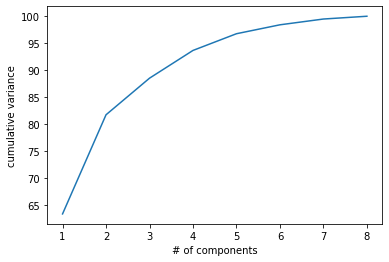

PCA(n_components=8)

In [85]:
pc_analysis(scaled, scaled.shape[1])

Let us set a cutoff cumulative variance of 90% to minimize collinearity but still maintain a feasible amount of data. 

Cumulative Variance:
[63.40817796 81.75973155 88.53316772 93.67108239 96.76348465 98.41494667
 99.48516643]


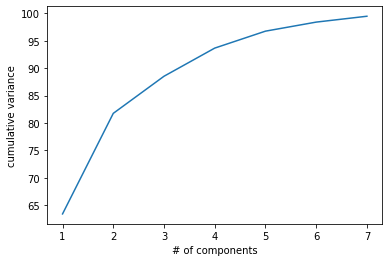

In [86]:
x = pc_analysis(scaled, 0.99)
x_scale = x.transform(scaled)
pca_df = pd.DataFrame(x_scale)

### Manual Selection

For manual selection, we can create a heatmap amongst the column to check for multicollinearity.

                  Mas Vnr Area  Total Bsmt SF  1st Flr SF  Gr Liv Area  \
Mas Vnr Area          1.000000       0.393530    0.392280     0.400703   
Total Bsmt SF         0.393530       1.000000    0.800429     0.445108   
1st Flr SF            0.392280       0.800429    1.000000     0.562166   
Gr Liv Area           0.400703       0.445108    0.562166     1.000000   
Full Bath             0.254471       0.325434    0.371584     0.630321   
Garage Cars           0.356646       0.437861    0.439370     0.488854   
Garage Area           0.370479       0.485608    0.491208     0.483971   
years_until_sold     -0.192819      -0.299078   -0.242987    -0.318549   

                  Full Bath  Garage Cars  Garage Area  years_until_sold  
Mas Vnr Area       0.254471     0.356646     0.370479         -0.192819  
Total Bsmt SF      0.325434     0.437861     0.485608         -0.299078  
1st Flr SF         0.371584     0.439370     0.491208         -0.242987  
Gr Liv Area        0.630321     0.488

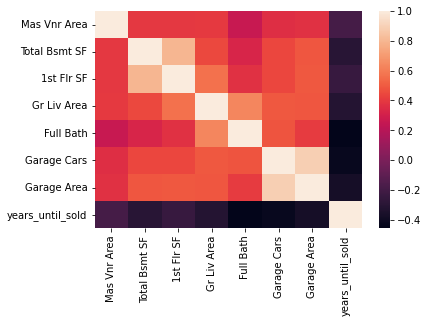

In [87]:
heatmap_corrs = scaled.corr()
print(heatmap_corrs)
sns.heatmap(heatmap_corrs)
plt.show()

We will eliminate columns Garage Cars becasue Garage Cars and Garage Area have high correlations and the column descriptions suggest similarity. 

In [88]:
man_scaled = scaled.drop(['Garage Cars'], axis=1)

We will also have to evaluate the variances, we can create a cutoff variance of a minimum of 1%.

In [89]:
fman_sc_cols = variance_cutoff(man_scaled, 0.01)
fman_sc = man_scaled[fman_sc_cols]

# Feature Selection: Object Columns¶

Upon converting 3 numerical features to categorial features, we will now be considering all object columns and evelauting whether they can be classified as categorial. If they are, we will then evaluate them based on the number of possible categories. The reason for this is if a column possesses a large number of categories, dummy coding the categories will lead to a far larger dataframe and a high processing time. 

We will be implementing 2 targets, we will eliminate all categorial columns with 10 or more unique values to prevent long processing times as we dummy the category columns and we will eliminate categorial columns that have 95% of the same value.

In [90]:
# Creating a merged list of all categorial data
housetr = housetr.select_dtypes(include=['object']).astype('category')
objects = housetr.select_dtypes(include=['category'])
categs = pd.concat([objects, num_categs], axis=1)

In [91]:
cleaned_columns = []
for col in categs.columns: 
    flag = False
    vals = categs[col].value_counts()
    for val in vals: 
        if (val)/(categs.shape[0])>0.95:
            flag = True
    if len(vals)>=10:
        flag=True
    if flag==True:
        continue 
    else:
        cleaned_columns.append(col)
categf = categs[cleaned_columns]

# Testing

For the testing, we will perform an analysis to see whether PCA or Manual Selection performed better. Furthermore, with the better numerical dataset, we will perform a sensitivity analysis about which categorial column alongside produces the lowest RMSE. With the best categorial column then, we will peform another sensitivity analysis to see which k value will produce the lowest RMSE. 

### PCA vs. Manual Selection

In [92]:
pca_final = pca_df
pca_final['SalePrice'] = house['SalePrice']
manual_final = fman_sc
manual_final['SalePrice'] = house['SalePrice']
print('The Average RMSE value with the PCA technique is {}.'.format(train_and_test(pca_final,2)))
print('The Average RMSE value with the manual technique is {}.'.format(train_and_test(manual_final,2)))

The Average RMSE value with the PCA technique is 40808.921253681154.
The Average RMSE value with the manual technique is 49642.08556011526.


We can see, as expected, PCA offers a far lower RMSE value. We will therefore proceed with the PCA dataset in the further analyses.

### Sensitivity Analysis: Categorial Column

In [93]:
merged = pd.concat([pca_df, pd.get_dummies(categf.iloc[:,1])], axis=1)
merged.head()

,0,1,2,3,4,5,6,SalePrice,IR1,IR2,IR3,Reg
0,-0.377586,0.231773,-0.073576,0.054457,0.084317,0.041142,-0.036124,215000,1,0,0,0
1,-0.425002,0.099384,-0.148185,-0.022688,0.017611,-0.022976,0.221749,105000,0,0,0,1
2,-0.501501,0.039919,0.022015,0.099393,0.082344,-0.010819,0.001587,172000,1,0,0,0
3,-0.181477,0.282105,0.146655,-0.031982,0.230071,-0.035898,-0.038023,244000,0,0,0,1
4,0.194331,-0.051871,0.036855,-0.112252,-0.030984,0.007441,-0.009607,189900,1,0,0,0


In [107]:
rmses = {} 
reference = pca_df
reference['SalePrice'] = house['SalePrice']
for col in categf.columns:
    merged = pd.concat([pca_df, pd.get_dummies(categf[col])], axis=1)
    test = train_and_test(merged, 2)
    rmses[col] = test 
print(min(rmses, key=lambda x: rmses[x]))

Bsmt Qual


We can see that Bsmt Qual categorial column leads to the lowest RMSE. 

### Sensitivity Analysis: K Fold Value

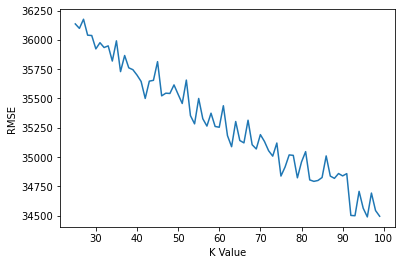

In [116]:
rmses = []
kfold_df = pd.concat([pca_df,pd.get_dummies(categf['Bsmt Qual'])], axis=1)
for k in range(25,100):
    test = train_and_test(kfold_df, k)
    rmses.append(test)
plt.plot(range(25,100), rmses)
plt.xlabel('K Value')
plt.ylabel('RMSE')
plt.show()

It can be seen that as we increase the k value, signifying a higher number of splits of data as we test linear regression, it leads to a lower RMSE. Let us perform hold one out evaluation to see if that would expectedly decrease the RMSE.

In [117]:
print(train_and_test(kfold_df, kfold_df.shape[0]))

23708.78103401199


We can see that a hold one out evaluation signifcantly decreased the RMSE value to ~23000. The RMSE is not low enough to justify the model's accurate predictions, however, further feature engineering and using multiple categorial columns may decrease the RMSE even further. Furthermore, Chi-squared tests could also be considered for feature selection for the categorial columns.